In [4]:
##Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from collections import Counter

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
"""Generate Simulated Data"""

def generate_data(n, d, k, mu_0, mu_1, mu_2, tmp, evals):
    #Generate covariance sigma

    cov_sigma = tmp * evals * tmp.T
    phi_1 = 0.3
    phi_2 = 0.4
    phi_3 = 0.3
    #Generate class labels
    #X, y = make_classification(n_samples=n, n_features=d, n_classes=k, n_clusters_per_class=1, weights=(0.3,0.4,0.3), random_state=42)
    X = np.empty((n, d))
    y = np.random.choice([0, 1, 2], size=(n, 1), p=[phi_1, phi_2, phi_3])
    
    for ii in range(n):
        if (y[ii] == 0):
            X_raw = cov_sigma @ np.random.randn(d, 1) + mu_0

        if (y[ii] == 1):
            X_raw = cov_sigma @ np.random.randn(d, 1) + mu_1
            
        if (y[ii] == 2):
            X_raw = cov_sigma @ np.random.randn(d, 1) + mu_2


        X[ii:ii + 1, :] = X_raw.T
    
    return X, y


In [76]:
"""Implement k-means clustering with multiple random initializations to pick the best one with smallest cost"""

def kmeans_cluster(X_train1, X_test1, k):
        scaler = StandardScaler()
        X_train1 = scaler.fit_transform(X_train1)
        Kmean = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=42)
        Kmean.fit(X_train1)
        mu_hat = Kmean.cluster_centers_
        kmean_cost = (Kmean.inertia_)/X_train1.shape[0]
        y_pred = Kmean.predict(X_test1)
        
        return y_pred, kmean_cost

def find_min_cost(n, d, k, max_iter, evals):
    np.random.seed(1)
    kmean_cost = []
    #min_mu = []
    for i in range(max_iter):
        ##lot of separation between the means, then the data will be "separable"
        mu_0 = 1 * np.random.randn(d, 1)
        mu_1 = 2 * np.random.randn(d, 1)
        mu_2 = 3 * np.random.randn(d, 1)

        tmp = np.random.randn(d, d)
        #evals = np.diag(np.concatenate((100 * np.random.randn(round(d/8),1), np.random.randn(d - round(d/8),1))) ** 2)

        X1, y1 = generate_data(n, d, k, mu_0, mu_1, mu_2, tmp, evals)
        #print(X1.shape, y1.shape)

        X_train1 = X1[0:35, 0:d]
        y_train1 = y1[0:35]
        X_test1 = X1[35:n, 0:d]
        y_test1 = y1[35:n]

        #print("***Simulated Data for evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2]***")
        #print('X Shape : ', X1.shape)
        #print('y Shape : ', y1.shape)
        #print('X_train Shape : ', X_train1.shape)
        #print('y_train Shape : ', y_train1.shape)
        #print('X_test Shape : ', X_test1.shape)
        #print('y_test Shape : ', y_test1.shape)
        
        y_hat, cost_function = kmeans_cluster(X_train1, X_test1, k)
        kmean_cost.append(cost_function)
        
        if kmean_cost[i] < kmean_cost[i-1]:
            min_mu1 = [mu_0, mu_1, mu_2]

    return kmean_cost, min_mu1

In [59]:
"""Select best 'r' after applying PCA"""

def select_rank_r(X, y, X_test, y_test):
    """
    return an optimal rank of the approximation matrix based on the test MSE and a plot of test MSE against the number of features
    return: r is the optimal rank of the approximation matrix
    """
    if X.shape[0] != y.shape[0]:
        raise Exception("X and y must have the same dimension")
    elif X_test.shape[0] != y_test.shape[0]:
        raise Exception("X_test and y_test must have the same dimension")
    max_iter = 1000
    alpha = 1e-2
    m = X.shape[0]
    n = X.shape[1]
    one_mat = np.ones((n,1))
    #print(one_mat.shape)
    #mu_hat = np.sum(X) / X.shape[0]
    mu_hat = X.mean(axis=0)
    #print(mu_hat.shape)
    Z = X - np.dot(mu_hat.T, one_mat)
    #print(Z.shape)
    U_full, S_full, V_full = np.linalg.svd(Z)

    test_error = []
    accuracy = []
    for i in range(1, X.shape[1]):
        V = np.transpose(V_full)[:, 0:i]
        B = np.dot(X, V)
        #print(B.shape)
        #adding mean term
        c_hat = np.ones(B.shape[0]).reshape(B.shape[0], 1)
        B = np.concatenate((c_hat, B), axis=1)
        #print('B = ', B.shape)

        y_hat, cost_function = kmeans_cluster(B[:, 0:(i+1)], X_test[:, 0:(i+1)], k)
        accuracy.append(accuracy_score(y_test, y_hat))
            
        error_metric = error_estimate(y_test, y_hat)
        #print(error_metric)
        test_error.append(error_metric)

    r = np.argmin(test_error) + 1
    #plot_content = (np.arange(0, len(test_mse), 1), np.log(test_mse))

    return r, test_error, accuracy

def error_estimate(y_test, y_hat):

    ##Testing error of each method
    error_metric = (np.sum(np.abs(y_test - y_hat)))/y_test.shape[0]

    return error_metric

def plot_figure(test_mse, accuracy):
    plt.figure(figsize=(12,8))
    plt.plot(test_mse, label='Test Error', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Test Error')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Test Error per number of Principal Components", fontsize=20)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(accuracy, label='Accuracy', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Accuracy per number of Principal Components", fontsize=20)
    plt.show()

In [83]:
##Question-5.a) - Implement k-means clustering with multiple random initializations to pick the best one with smallest cost
n = 50
d = 200
max_iter = 10
alpha = 1e-2
k = 3
tmp = np.random.randn(d, d)
evals = np.diag(np.concatenate((100 * np.random.randn(round(d/8),1), np.random.randn(d - round(d/8),1))) ** 2)
kc, min_mu = find_min_cost(n, d, k, max_iter, evals)
#print(min(kc))
mu_0_hat = min_mu[0]
mu_1_hat = min_mu[1]
mu_2_hat = min_mu[2]

In [78]:
#Generating simulated data - 1
"""
simulated data with evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2])
"""
X1, y1 = generate_data(n, d, k, mu_0_hat, mu_1_hat, mu_2_hat, tmp, evals)

#print(X1.shape, y1.shape)

X_train1 = X1[0:35, 0:d]
y_train1 = y1[0:35]
X_test1 = X1[35:n, 0:d]
y_test1 = y1[35:n]

print("***Simulated Data for evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2]***")
print('X Shape : ', X1.shape)
print('y Shape : ', y1.shape)
print('X_train Shape : ', X_train1.shape)
print('y_train Shape : ', y_train1.shape)
print('X_test Shape : ', X_test1.shape)
print('y_test Shape : ', y_test1.shape)

***Simulated Data for evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2]***
X Shape :  (50, 200)
y Shape :  (50, 1)
X_train Shape :  (35, 200)
y_train Shape :  (35, 1)
X_test Shape :  (15, 200)
y_test Shape :  (15, 1)



***Implementing k-means clustering with PCA***
Best value of r for K-Means Clustering with PCA =  23
Minimum value of error for K-Means Clustering with PCA =  12.8
Accuracy of K-Means Clustering with PCA =  0.6


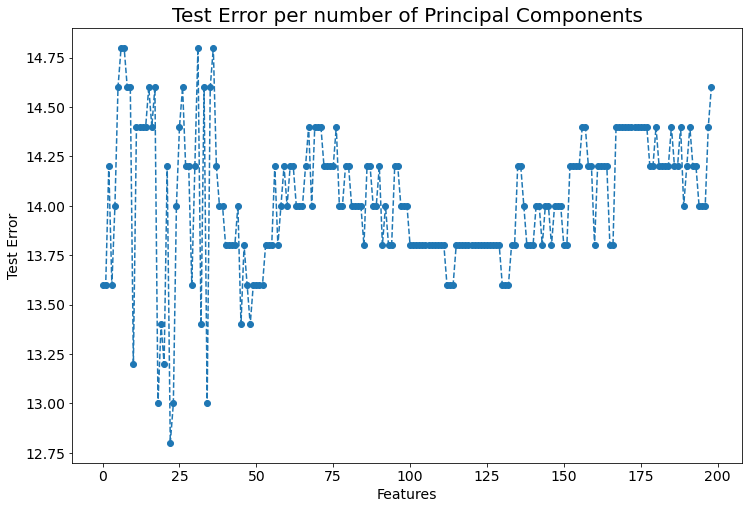

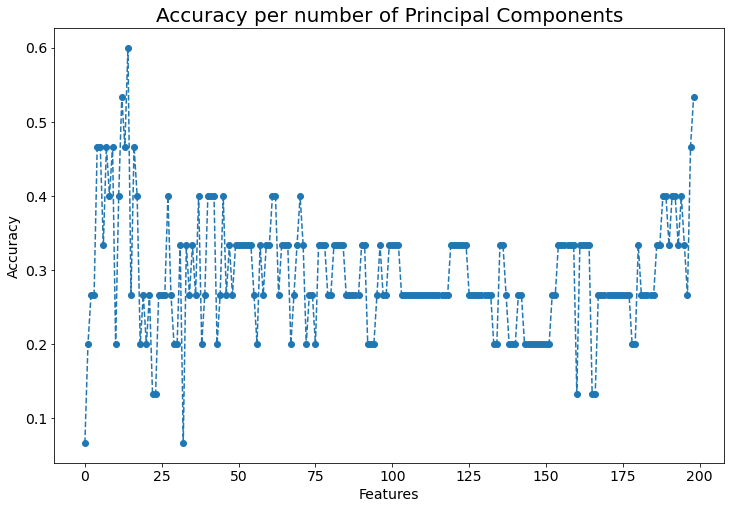

In [79]:
"""Implementing k-means clustering with PCA to decide best value of r"""
r1, test_error1, accuracy1 = select_rank_r(X_train1, y_train1, X_test1, y_test1)
print("\n***Implementing k-means clustering with PCA***")
print('Best value of r for K-Means Clustering with PCA = ', r1)
print('Minimum value of error for K-Means Clustering with PCA = ', min(test_error1))
print('Accuracy of K-Means Clustering with PCA = ', max(accuracy1))
plot_figure(test_error1, accuracy1)

In [81]:
##Question-4
#Generating simulated data - 2
"""
simulated data with evals = diag([100 * np.random.randn(d, 1)^2])
"""
evals2 = np.diag((100 * np.random.randn(d, 1) ** 2))
kc, min_mu = find_min_cost(n, d, k, max_iter, evals2)
#print(min(kc))
mu_0_hat = min_mu[0]
mu_1_hat = min_mu[1]
mu_2_hat = min_mu[2]

X2, y2 = generate_data(n, d, k, mu_0_hat, mu_1_hat, mu_2_hat, tmp, evals2)

#print(X1.shape, y1.shape)

X_train2 = X1[0:35, 0:d]
y_train2 = y1[0:35]
X_test2 = X1[35:n, 0:d]
y_test2 = y1[35:n]

print("***Simulated Data for evals = diag([100 * np.random.randn(d, 1)^2])***")
print('X Shape : ', X2.shape)
print('y Shape : ', y2.shape)
print('X_train Shape : ', X_train2.shape)
print('y_train Shape : ', y_train2.shape)
print('X_test Shape : ', X_test2.shape)
print('y_test Shape : ', y_test2.shape)

***Simulated Data for evals = diag([100 * np.random.randn(d, 1)^2])***
X Shape :  (50, 200)
y Shape :  (50, 1)
X_train Shape :  (35, 200)
y_train Shape :  (35, 1)
X_test Shape :  (15, 200)
y_test Shape :  (15, 1)



***Implementing k-means clustering with PCA***
Best value of r for K-Means Clustering with PCA =  23
Minimum value of error for K-Means Clustering with PCA =  12.8
Accuracy of K-Means Clustering with PCA =  0.6


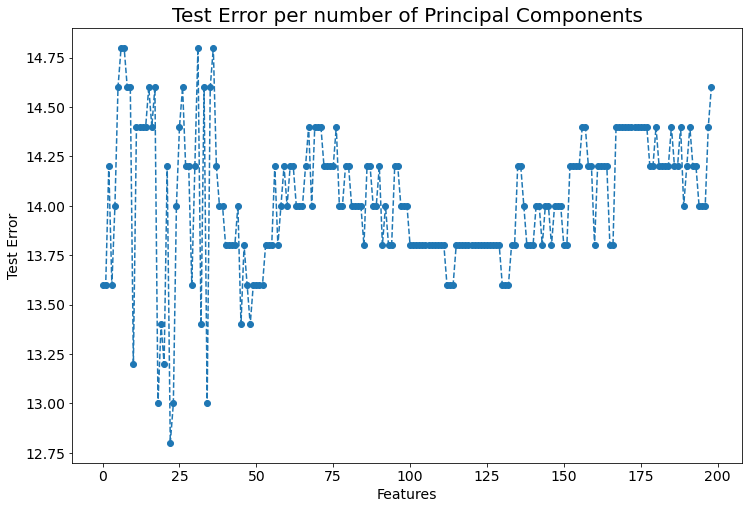

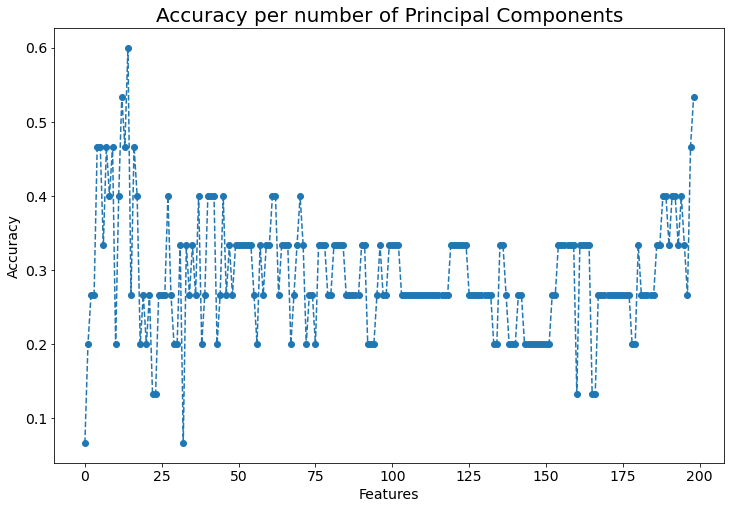

In [82]:
"""Implementing k-means clustering with PCA to decide best value of r"""
r2, test_error2, accuracy2 = select_rank_r(X_train2, y_train2, X_test2, y_test2)
print("\n***Implementing k-means clustering with PCA***")
print('Best value of r for K-Means Clustering with PCA = ', r2)
print('Minimum value of error for K-Means Clustering with PCA = ', min(test_error2))
print('Accuracy of K-Means Clustering with PCA = ', max(accuracy2))
plot_figure(test_error2, accuracy2)